In [1]:
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import collections as col
from IPython.display import IFrame
from geopy import distance
import statistics
# ox.config(log_console=True, use_cache=True)
import geopy
from geopy import distance

# enums
node_size_enum = {0:0.2, 0.5:0.4, 1.0:0.8, 1.5:1.6, 2.0:3.2, 2.5:6.4, 3.0:12.8, 3.5:25.6, 4.0:51.2, 4.5: 102.4, 5.0: 204.8}


ModuleNotFoundError: No module named 'matplotlib'

In [10]:
node_cols = {'business_id','name','address','city','state','postal_code','latitude','longitude','stars','review_count','is_open','attributes','categories','hours'}
edge_cols = {'Source', 'Target'}

edges = pd.DataFrame()

nodes = pd.read_csv('yelp_academic_dataset_business_TX.csv', usecols = node_cols)
nodes['categories'].replace('', np.nan, inplace=True) # Remove rows with blank cells
nodes.dropna(subset=['categories'], inplace=True)

toy_base = ''
toy_base2 = ''
for index, row in nodes.iterrows():
    categories = row['categories'].split(", ")
    if row['postal_code'] != 78701 and row['postal_code'] != 78704 and row['postal_code'] != 78751:
        nodes.drop(index, inplace=True)
    elif row['is_open'] == 0:
        nodes.drop(index, inplace=True)
    elif 'Restaurants' not in categories and 'Food' not in categories:
        nodes.drop(index, inplace=True)
    elif row['name']  == 'Voodoo Doughnut - 6th Street':
        toy_base = row
    elif row['name'] == "Mrs Johnson's Bakery":
        toy_base2 = row
        
# clean up categories
for index, row in nodes.iterrows():
    row['categories'] = [s.replace("'", "") for s in row['categories']]
    row['categories'] = [x.strip(' ') for x in row['categories']]
#     print(type(row['categories']))


In [12]:
for index, row in nodes.iterrows():
    row['categories'] = row['categories'].split(', ')
# print(nodes['categories'])

cats_file = open("cats_list.txt.csv")
file_contents = cats_file.read()
contents_split = file_contents.splitlines()
contents_split = [s.replace("'", "") for s in contents_split]
cats_list = [x.strip(' ') for x in contents_split]
# print(cats_list)

In [19]:
# Create graph
G = nx.Graph()
for index, row in nodes.iterrows():
    G.add_node(row['business_id'], name=row['name'], address=row['address'],city=row['city'],state=row['state'],postal_code=row['postal_code'],lat=row['latitude'],lon=row['longitude'],stars=row['stars'],review_count=row['review_count'],is_open=row['is_open'],attributes=row['attributes'],categories=set(row['categories'].split(', ')).intersection(cats_list),hours=row['hours'])    
#     print(set(row['categories'].split(', ')).intersection(cats_list))
edges_near = pd.DataFrame()
edges_far = pd.DataFrame()
# Add edges to restaurants in 300 ft radius of voodoo
radius = 0.0568182 # radius in miles (300 feet)

for n, n_d in G.nodes.items():
    center = tuple([toy_base['latitude'], toy_base['longitude']])
    target = tuple([n_d['lat'], n_d['lon']])
    src_cats = G.nodes['-oCYfB-JL3Yc_RECg4B1Qw']['categories']
    targ_cats = n_d['categories']
    dis = distance.distance(center, target).miles
    if dis < radius and n_d['name'] != toy_base['name']:
        edges_near = edges_near.append({'Source':toy_base['business_id'], 'Target':n}, ignore_index = True)
        G.add_edge(toy_base['business_id'], n, color='bl', weight=2)
    if len(set(src_cats).intersection(targ_cats)) > 0 and n != '-oCYfB-JL3Yc_RECg4B1Qw':
        G.add_edge(toy_base['business_id'], n, color='p',weight=2)
        edges_far = edges_far.append({'Source':toy_base['business_id'], 'Target':n}, ignore_index = True)
for n, n_d in G.nodes.items():
    center = tuple([toy_base2['latitude'], toy_base2['longitude']])
    target = tuple([n_d['lat'], n_d['lon']])
    src_cats = G.nodes['-oCYfB-JL3Yc_RECg4B1Qw']['categories']
    targ_cats = n_d['categories']
    dis = distance.distance(center, target).miles
    if dis < radius and n_d['name'] != toy_base['name']:
        edges_near = edges_near.append({'Source':toy_base2['business_id'], 'Target':n}, ignore_index = True)
        G.add_edge(toy_base2['business_id'], n, color='bl', weight=2)
    if len(set(src_cats).intersection(targ_cats)) > 0 and n != '-oCYfB-JL3Yc_RECg4B1Qw':
        G.add_edge(toy_base2['business_id'], n, color='p',weight=2)
        edges_far = edges_far.append({'Source':toy_base2['business_id'], 'Target':n}, ignore_index = True)

        
# Calc optimal distance
# Voodoo
opt_dis = 0
opt_dists = []
opt_neighbors = []
opt_stars = 0
min_stars = 5
min_neighbor = []
min_dis = 0
for neighbor in G.neighbors('-oCYfB-JL3Yc_RECg4B1Qw'):
    center = tuple([toy_base['latitude'], toy_base['longitude']])
    target = tuple([G.nodes[neighbor]['lat'], G.nodes[neighbor]['lon']])
#     print(G.nodes.data) 
    if opt_stars < G.nodes[neighbor]['stars']:
        opt_dis = distance.distance(center, target).miles
#         opt_neighbor = neighbor
        opt_stars = G.nodes[neighbor]['stars']
    if min_stars > G.nodes[neighbor]['stars']:
        min_stars = G.nodes[neighbor]['stars']
        min_dis = distance.distance(center, target).miles
        min_neighbor = neighbor

for neighbor in G.neighbors('-oCYfB-JL3Yc_RECg4B1Qw'):
    center = tuple([toy_base['latitude'], toy_base['longitude']])
    target = tuple([G.nodes[neighbor]['lat'], G.nodes[neighbor]['lon']])
    src_cats = G.nodes['-oCYfB-JL3Yc_RECg4B1Qw']['categories']
    targ_cats = G.nodes[neighbor]['categories']
    if G.nodes[neighbor]['stars'] == opt_stars:
        if len(set(src_cats).intersection(targ_cats)) > 0:
            opt_dists.append(distance.distance(center, target).miles)
            opt_neighbors.append(neighbor)

print(opt_dis, opt_stars, opt_dists, opt_neighbors, statistics.mean(opt_dists))

# Mrs. Johnson's
opt_dis = 0
opt_dists = []
opt_neighbors = []
opt_stars = 0
min_stars = 5
min_neighbor = []
min_dis = 0
for neighbor in G.neighbors('nMcCoHAqw7KIrILBIkiWEQ'):
    center = tuple([toy_base2['latitude'], toy_base2['longitude']])
    target = tuple([G.nodes[neighbor]['lat'], G.nodes[neighbor]['lon']])
#     print(G.nodes.data) 
    if opt_stars < G.nodes[neighbor]['stars']:
        opt_dis = distance.distance(center, target).miles
#         opt_neighbor = neighbor
        opt_stars = G.nodes[neighbor]['stars']
    if min_stars > G.nodes[neighbor]['stars']:
        min_stars = G.nodes[neighbor]['stars']
        min_dis = distance.distance(center, target).miles
        min_neighbor = neighbor

for neighbor in G.neighbors('nMcCoHAqw7KIrILBIkiWEQ'):
    center = tuple([toy_base2['latitude'], toy_base2['longitude']])
    target = tuple([G.nodes[neighbor]['lat'], G.nodes[neighbor]['lon']])
    src_cats = G.nodes['nMcCoHAqw7KIrILBIkiWEQ']['categories']
    targ_cats = G.nodes[neighbor]['categories']
    if G.nodes[neighbor]['stars'] == opt_stars:
        if len(set(src_cats).intersection(targ_cats)) > 0:
            opt_dists.append(distance.distance(center, target).miles)
            opt_neighbors.append(neighbor)

print(opt_dis, opt_stars, opt_dists, opt_neighbors, statistics.mean(opt_dists))

# for neighbor in G.neighbors('-oCYfB-JL3Yc_RECg4B1Qw'):
#     print(G.nodes[neighbor]['lat'])
count1 = 0
count2 = 0
for index, row in edges_far.iterrows():
    if row['Source'] == toy_base['business_id']:
        count1+= 1
    elif row['Source'] == toy_base2['business_id']:
        count2+= 1
print(count1)
print(count2)
count1 = 0
count2 = 0
for index, row in edges_near.iterrows():
    if row['Source'] == toy_base['business_id']:
        count1+= 1
    elif row['Source'] == toy_base2['business_id']:
        count2+= 1
print(count1)
print(count2)

3.2051341264336943 5.0 [3.2051341264336943, 3.5746004406209106, 0.409952513177164, 1.9161029027476078, 2.0849622245976467] ['7gmWYbCPZRtGCq7W3egclw', '_VcTzv8XUhfanoxiUfqPlQ', '808JwvDGIJeXuFG0rLaepA', 'hYWsMDz0ms7TOnFTcsxYcw', 'QlpNG4q2tBLo2arUlJoHBA'] 2.2381504415154048
6.310086049157111 5.0 [6.310086049157111, 0.3675936070889259, 3.099363050452412, 5.2033154384236395, 5.129059684361405] ['7gmWYbCPZRtGCq7W3egclw', '_VcTzv8XUhfanoxiUfqPlQ', '808JwvDGIJeXuFG0rLaepA', 'hYWsMDz0ms7TOnFTcsxYcw', 'QlpNG4q2tBLo2arUlJoHBA'] 4.021883565896698
38
38
8
3


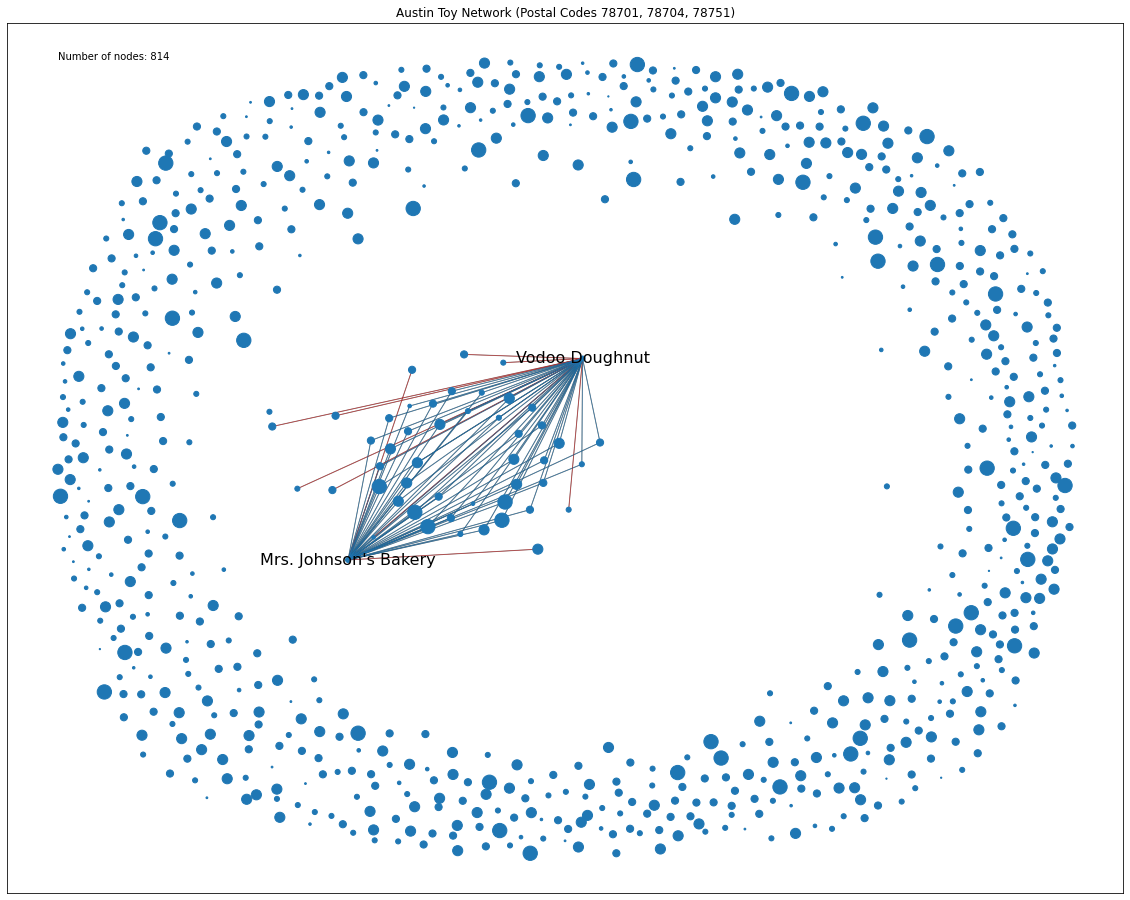

In [391]:
plt.figure(1,figsize=(20,16))
pos = nx.spring_layout(G, k=0.15, iterations=20)
edges_list = G.edges
pos['nMcCoHAqw7KIrILBIkiWEQ'] = pos['nMcCoHAqw7KIrILBIkiWEQ'] - 0.25
pos['-oCYfB-JL3Yc_RECg4B1Qw'] = pos['-oCYfB-JL3Yc_RECg4B1Qw'] + 0.25
# print((pos['nMcCoHAqw7KIrILBIkiWEQ']))

# nodes
node_size = []
for n, n_d in G.nodes.items():
    node_size.append(node_size_enum[n_d['stars']])  # Node size is a function of rating
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=G.nodes, 
                       node_color="tab:blue", 
                       node_size=node_size,)
nx.draw_networkx_labels(G,
                        pos,
                        {'nMcCoHAqw7KIrILBIkiWEQ':"Mrs. Johnson's Bakery", 
                               '-oCYfB-JL3Yc_RECg4B1Qw':"Vodoo Doughnut"},
                        font_size=16,
                        font_color='black')

# Node positions
# pos = {}
# for n, n_d in G.nodes.items():
#     pos[n]=(n_d['lat'], n_d['lon'])
# nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color="tab:blue", node_size=node_size)
# m.drawcountries(linewidth = 2)
# m.drawstates(linewidth = 0.2)
# m.drawcoastlines(linewidth=2)
# plt.tight_layout()
# plt.savefig("map.png", dpi = 300)
# plt.show()
# print(G.nodes.data())

# nx.draw(G,pos,node_size = 5, width = 1, edge_colors=colors)
#edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=list(edges_near.to_records(index=False)),
    width=0.6,
    alpha=0.8,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=list(edges_far.to_records(index=False)),
    width=0.6,
    alpha=0.8,
    edge_color="tab:blue",
)
plt.text(-1,1,"Number of nodes: {}".format(G.number_of_nodes()))
plt.title("Austin Toy Network (Postal Codes 78701, 78704, 78751)")

# Export nodes as spreadsheet for GEPHI
nodes_csv = pd.DataFrame(columns = ['id', 'lat', 'lon', 'stars'])
edges_csv = pd.DataFrame(columns = ['src', 'target'])
for n, n_d in G.nodes.items():
    nodes_csv = nodes_csv.append({'id' :n, 'lat':n_d['lat'], 'lon':n_d['lon'], 'stars':n_d['stars']}, ignore_index = True)
nodes_csv.to_excel("nodes_csv.xlsx")  
# nx.write_edgelist(G, "edgelist.csv", delimiter=',')


In [20]:
# Small town challenge w/ Buda, TX

node_cols = {'business_id','name','address','city','state','postal_code','latitude','longitude','stars','review_count','is_open','attributes','categories','hours'}
edge_cols = {'Source', 'Target'}

nodes_buda = pd.read_csv('yelp_academic_dataset_business_TX.csv', usecols = node_cols)
nodes_buda['categories'].replace('', np.nan, inplace=True) # Remove rows with blank cells
nodes_buda.dropna(subset=['categories'], inplace=True)

buda_base = ''
buda_base2 = ''
for index, row in nodes_buda.iterrows():
    categories = row['categories'].split(", ")
    if row['city'] != 'Buda':
        nodes_buda.drop(index, inplace=True)
    elif row['is_open'] == 0:
        nodes_buda.drop(index, inplace=True)
    elif 'Restaurants' not in categories and 'Food' not in categories:
        nodes_buda.drop(index, inplace=True)
    elif row['name']  == 'Bat Wings':
        buda_base = row
    elif row['name']  == 'Burger King':
        buda_base2 = row

# clean up categories
for index, row in nodes_buda.iterrows():
    row['categories'] = [s.replace("'", "") for s in row['categories']]
    row['categories'] = [x.strip(' ') for x in row['categories']]
#     print(type(row['categories']))

In [21]:
for index, row in nodes_buda.iterrows():
    row['categories'] = row['categories'].split(', ')
# print(nodes['categories'])
cats_file = open("cats_list.txt.csv")
file_contents = cats_file.read()
contents_split = file_contents.splitlines()
contents_split = [s.replace("'", "") for s in contents_split]
cats_list = [x.strip(' ') for x in contents_split]

In [25]:
# Create graph
G_b = nx.Graph()
# Add node attributes
for index, row in nodes_buda.iterrows():
    G_b.add_node(row['business_id'], name=row['name'], address=row['address'],city=row['city'],state=row['state'],postal_code=row['postal_code'],lat=row['latitude'],lon=row['longitude'],stars=row['stars'],review_count=row['review_count'],is_open=row['is_open'],attributes=row['attributes'],categories=set(row['categories'].split(', ')).intersection(cats_list),hours=row['hours'])    
# G_b.add_nodes_from(nodes_buda['business_id'])
edgesb_near = pd.DataFrame()
edgesb_far = pd.DataFrame()
# Add edges to restaurants in 1 muile radius of voodoo
radius = 0.0568182 # radius in miles (300 feet)

# print(nodes.loc[nodes['name'] == "Gourdough's Big Fat Donuts"])

# Make edges between voodoo dougnut and resturants not within radius, or voodoo doughnut and other donut places
# for index, row in nodes_buda.iterrows():
#     center = tuple([buda_base['latitude'], buda_base['longitude']])
#     target = tuple([row['latitude'], row['longitude']])

#     src_cats = buda_base['categories'].split(", ")
#     targ_cats = row['categories'].split(", ")
    
#     dis = distance.distance(center, target).miles
#     if dis < radius and row['name'] != buda_base['name']:
#         edgesb_near = edgesb_near.append({'Source':buda_base['business_id'], 'Target':row['business_id']}, ignore_index = True)
#         G_b.add_edge(buda_base['business_id'], row['business_id'], color='bl', weight=2)
#     elif 'Burgers' in targ_cats and row['name'] != buda_base['name']:
#         G_b.add_edge(buda_base['business_id'], row['business_id'], color='p',weight=2)
#         edgesb_far = edgesb_far.append({'Source':buda_base['business_id'], 'Target':row['business_id']}, ignore_index = True)

# Bat Wings
for n, n_d in G_b.nodes.items():
    center = tuple([buda_base['latitude'], buda_base['longitude']])
    target = tuple([n_d['lat'], n_d['lon']])
    src_cats = G_b.nodes['gxp6M4rvIXFKo-jlsci_Hw']['categories']
    targ_cats = n_d['categories']
    dis = distance.distance(center, target).miles
    if dis < radius and n_d['name'] != buda_base['name']:
        edgesb_near = edgesb_near.append({'Source':buda_base['business_id'], 'Target':n}, ignore_index = True)
        G_b.add_edge(buda_base['business_id'], n, color='bl', weight=2)
    if len(set(src_cats).intersection(targ_cats)) > 0 and n != 'gxp6M4rvIXFKo-jlsci_Hw':
#         print(set(src_cats).intersection(targ_cats))
        G_b.add_edge(buda_base['business_id'], n, color='p',weight=2)
        edgesb_far = edgesb_far.append({'Source':buda_base['business_id'], 'Target':n}, ignore_index = True)
# Calc optimal distance
opt_dis = 0
opt_dists = []
opt_neighbors = []
opt_stars = 0
min_stars = 5
min_neighbor = []
min_dis = 0
for neighbor in G_b.neighbors('gxp6M4rvIXFKo-jlsci_Hw'):
    center = tuple([buda_base['latitude'], buda_base['longitude']])
    target = tuple([G_b.nodes[neighbor]['lat'], G_b.nodes[neighbor]['lon']])
#     print(G.nodes.data) 
    if opt_stars < G_b.nodes[neighbor]['stars']:
        opt_dis = distance.distance(center, target).miles
#         opt_neighbor = neighbor
        opt_stars = G_b.nodes[neighbor]['stars']
    if min_stars > G_b.nodes[neighbor]['stars']:
        min_stars = G_b.nodes[neighbor]['stars']
        min_dis = distance.distance(center, target).miles
        min_neighbor = neighbor
# Find neighbors
for neighbor in G_b.neighbors('gxp6M4rvIXFKo-jlsci_Hw'):
    center = tuple([buda_base['latitude'], buda_base['longitude']])
    target = tuple([G_b.nodes[neighbor]['lat'], G_b.nodes[neighbor]['lon']])
    if G_b.nodes[neighbor]['stars'] == opt_stars:
        if len(set(src_cats).intersection(targ_cats)) > 0:
            opt_dists.append(distance.distance(center, target).miles)
            opt_neighbors.append(neighbor)

print(opt_dis, opt_stars, opt_dists, opt_neighbors, statistics.mean(opt_dists))

# Burger King
for n, n_d in G_b.nodes.items():
    center = tuple([buda_base2['latitude'], buda_base2['longitude']])
    target = tuple([n_d['lat'], n_d['lon']])
    src_cats = G_b.nodes['IFLmuNjeRBEv9lMbvHo_zg']['categories']
    targ_cats = n_d['categories']
    dis = distance.distance(center, target).miles
    if dis < radius and n_d['name'] != buda_base2['name']:
        edgesb_near = edgesb_near.append({'Source':buda_base2['business_id'], 'Target':n}, ignore_index = True)
        G_b.add_edge(buda_base2['business_id'], n, color='bl', weight=2)
    if len(set(src_cats).intersection(targ_cats)) > 0 and n != 'IFLmuNjeRBEv9lMbvHo_zg':
#         print(set(src_cats).intersection(targ_cats))
        G_b.add_edge(buda_base2['business_id'], n, color='p',weight=2)
        edgesb_far = edgesb_far.append({'Source':buda_base2['business_id'], 'Target':n}, ignore_index = True)
# Calc optimal distance
opt_dis = 0
opt_dists = []
opt_neighbors = []
opt_stars = 0
min_stars = 5
min_neighbor = []
min_dis = 0
for neighbor in G_b.neighbors('IFLmuNjeRBEv9lMbvHo_zg'):
    center = tuple([buda_base2['latitude'], buda_base2['longitude']])
    target = tuple([G_b.nodes[neighbor]['lat'], G_b.nodes[neighbor]['lon']])
#     print(G.nodes.data) 
    if opt_stars < G_b.nodes[neighbor]['stars']:
        opt_dis = distance.distance(center, target).miles
#         opt_neighbor = neighbor
        opt_stars = G_b.nodes[neighbor]['stars']
    if min_stars > G_b.nodes[neighbor]['stars']:
        min_stars = G_b.nodes[neighbor]['stars']
        min_dis = distance.distance(center, target).miles
        min_neighbor = neighbor
# Find neighbors
for neighbor in G_b.neighbors('IFLmuNjeRBEv9lMbvHo_zg'):
    center = tuple([buda_base2['latitude'], buda_base2['longitude']])
    target = tuple([G_b.nodes[neighbor]['lat'], G_b.nodes[neighbor]['lon']])
    if G_b.nodes[neighbor]['stars'] == opt_stars:
        if len(set(src_cats).intersection(targ_cats)) > 0:
            opt_dists.append(distance.distance(center, target).miles)
            opt_neighbors.append(neighbor)

print(opt_dis, opt_stars, opt_dists, opt_neighbors, statistics.mean(opt_dists))
count1 = 0
count2 = 0
for index, row in edgesb_far.iterrows():
    if row['Source'] == buda_base['business_id']:
        count1+= 1
    elif row['Source'] == buda_base2['business_id']:
        count2+= 1
print(count1)
print(count2)
count1 = 0
count2 = 0
for index, row in edgesb_near.iterrows():
    if row['Source'] == buda_base['business_id']:
        count1+= 1
    elif row['Source'] == buda_base2['business_id']:
        count2+= 1
print(count1)
print(count2)

0.05091129718907471 4.5 [0.05091129718907471, 0.0, 0.0] ['h_CnbiWwcPH3uW6UTYkjrA', '4YbtvgImmojrN6TBhupTiw', 'LyhiNr25NfJEB2_qIRz9xA'] 0.016970432396358235
3.2575350928486104 3.5 [3.2575350928486104] ['gxp6M4rvIXFKo-jlsci_Hw'] 3.2575350928486104
13
13
3
0


                    Source                  Target
0   gxp6M4rvIXFKo-jlsci_Hw  IFLmuNjeRBEv9lMbvHo_zg
1   gxp6M4rvIXFKo-jlsci_Hw  2BT1-wngnceqB398iOP9Bg
2   gxp6M4rvIXFKo-jlsci_Hw  vO-frP4Cg7DQ9oaDx7xJzQ
3   gxp6M4rvIXFKo-jlsci_Hw  p9rpSwvxmcyGnh1dGX6HMQ
4   gxp6M4rvIXFKo-jlsci_Hw  GKPkyBwHaMdokCKcyo6eVQ
5   gxp6M4rvIXFKo-jlsci_Hw  b4N2W6pCqkGAm5LndX1bPQ
6   gxp6M4rvIXFKo-jlsci_Hw  aOGMsboJELr1j1ueeM2P1g
7   gxp6M4rvIXFKo-jlsci_Hw  -1Yu2HpGNvxWJHCe4pr70w
8   gxp6M4rvIXFKo-jlsci_Hw  Mu3-fy5IugOQVLz85-qIjA
9   gxp6M4rvIXFKo-jlsci_Hw  Vy5q4jkWEO3zvlCSD6qI6g
10  gxp6M4rvIXFKo-jlsci_Hw  3QWRL6M_BG40XHS2ZtWheg
11  gxp6M4rvIXFKo-jlsci_Hw  LuEYESJvpHi9ImTjVhM6Mw
12  gxp6M4rvIXFKo-jlsci_Hw  LyhiNr25NfJEB2_qIRz9xA
13  LuEYESJvpHi9ImTjVhM6Mw  gxp6M4rvIXFKo-jlsci_Hw
14  LuEYESJvpHi9ImTjVhM6Mw  2BT1-wngnceqB398iOP9Bg
15  LuEYESJvpHi9ImTjVhM6Mw  vO-frP4Cg7DQ9oaDx7xJzQ
16  LuEYESJvpHi9ImTjVhM6Mw  p9rpSwvxmcyGnh1dGX6HMQ
17  LuEYESJvpHi9ImTjVhM6Mw  GKPkyBwHaMdokCKcyo6eVQ
18  LuEYESJvpHi9ImTjVhM6Mw  b4N

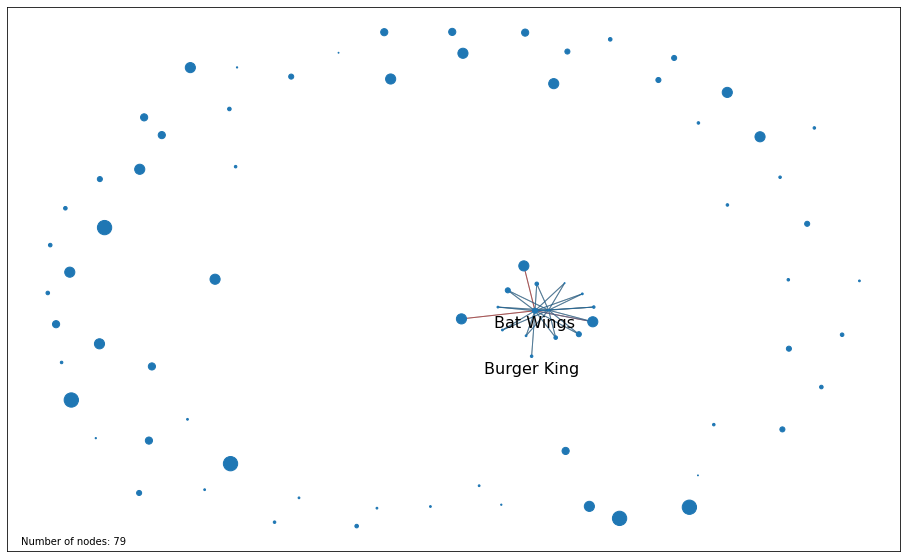

In [412]:
plt.figure(1,figsize=(16,10))
pos = nx.spring_layout(G_b, k=0.15, iterations=20)
edges_list = G_b.edges

# nodes
node_size = []
for n, n_d in G_b.nodes.items():
    node_size.append(node_size_enum[n_d['stars']])  # Node size is a function of rating
nx.draw_networkx_nodes(G_b, pos, nodelist=G_b.nodes, node_color="tab:blue", node_size=node_size)
labels = {'gxp6M4rvIXFKo-jlsci_Hw':'Bat Wings', 'IFLmuNjeRBEv9lMbvHo_zg':'Burger King'}

pos_higher = {}
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]-0.05)
nx.draw_networkx_labels(G_b,
                        pos_higher,
                        labels,
                        font_size=16,
                        font_color='black')
# nx.draw(G,pos,node_size = 5, width = 1, edge_colors=colors)
#edges
nx.draw_networkx_edges(G_b, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    G_b,
    pos,
    edgelist=list(edgesb_near.to_records(index=False)),
    width=1,
    alpha=0.5,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    G_b,
    pos,
    edgelist=list(edgesb_far.to_records(index=False)),
    width=1,
    alpha=0.5,
    edge_color="tab:blue",
)
plt.text(-1,-1,"Number of nodes: {}".format(G_b.number_of_nodes()))


<Figure size 432x288 with 0 Axes>

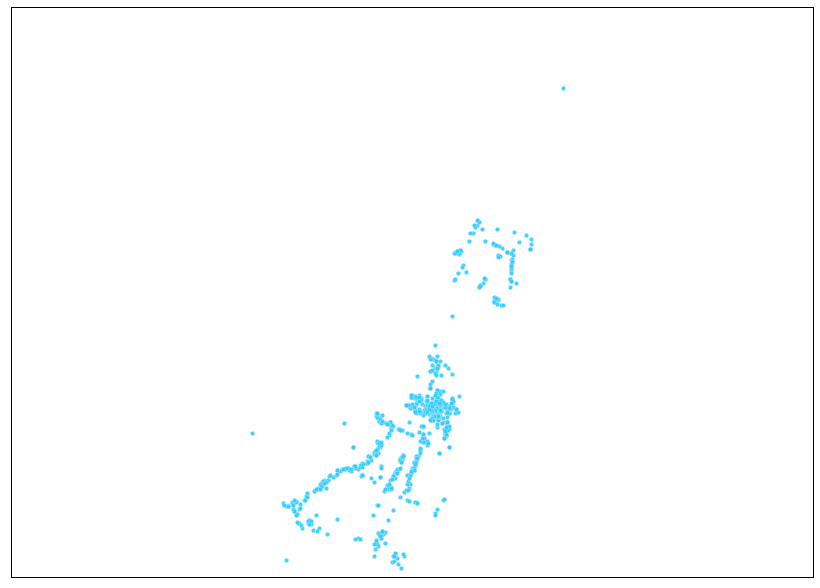

In [375]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, MultiPoint

m = Basemap(
        projection='merc',
        ellps = 'WGS84',
        llcrnrlon=-97.89488869769399,
        llcrnrlat=30.213755056343974,
        urcrnrlon=-97.606525,
        urcrnrlat=30.391656,
        lat_ts=-85,
        resolution='i',
        suppress_ticks=True)

# Create Point objects in map coordinates from dataframe lon
# and lat values
# I have a dataframe of coordinates
map_points = pd.Series(
                [Point(m(mapped_x, mapped_y)) 
                 for mapped_x, mapped_y in zip(nodes['longitude'],
                                               nodes['latitude'])])
amre_points = MultiPoint(list(map_points.values)) 

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.set_size_inches(18.5, 10.5)

# Create a scatterplot on the map
dev = m.scatter(
            [geom.x for geom in map_points],
            [geom.y for geom in map_points],
            20, marker='o', lw=.25,
            facecolor='#33ccff', edgecolor='w',
            alpha=0.9,antialiased=True,
            zorder=3)

m.fillcontinents(color='#FFFFFF')
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')
m.drawcountries(linewidth = 2)
m.drawstates(linewidth = 0.2)
# m.drawcoastlines(linewidth=2)


In [372]:
import osmnx as ox
ox.plot_graph(ox.graph_from_place('Modena, Italy'))


ModuleNotFoundError: No module named 'osmnx'

MapView(layout=Layout(height='400px', width='100%'))